# KMeans

### Predict
1. Initialize $K$ centroids randomly
2. Create clusters around centroids using the smallest euclidean distance
3. Iteratively create new centroids from clusters using cluster means
4. Break the loop if convergence criteria is met
5. Return the cluster labels

In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [22]:
class KMeans:

    def __init__(self, K = 5, n_iters=100):
        self.K = K
        self.n_iters = n_iters

        # Lists of sample indices
        self.clusters = [[] for _ in range(self.K)]
        # Mean for each cluster
        self.centroids = []

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum( ( x2 - x1 )**2 ))

    def predict(self, X):

        self.X = X
        self.n_samples, n_features = X.shape

        # Initialize centroids randomly
        centroids_idx = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = self.X[centroids_idx]

        for _ in range(self.n_iters):

            # Update clusters
            self.clusters = self._create_clusters(self.centroids)

            centroids_old = self.centroids

            # Calculate new centroids using cluster means
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids):

        clusters = [[] for _ in range(self.K)]

        for idx, x in enumerate(self.X):
            closest_centroid_idx = self._closest_centroid(x, centroids)
            clusters[closest_centroid_idx].append(idx)

        return clusters

    def _closest_centroid(self, sample, centroids):
        distances = np.array([self._euclidean_distance(sample, c) for c in centroids])
        return np.argmin(distances)
    
    def _get_centroids(self, clusters):
        centroids = [np.mean(self.X[c], axis=0) for c in clusters]
        return np.array(centroids)
    
    def _is_converged(self, old, new):
        distances = [self._euclidean_distance(old[i], new[i]) for i in range(self.K)]
        return sum(distances) == 0
    
    def _get_cluster_labels(self, clusters):
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx
        return labels

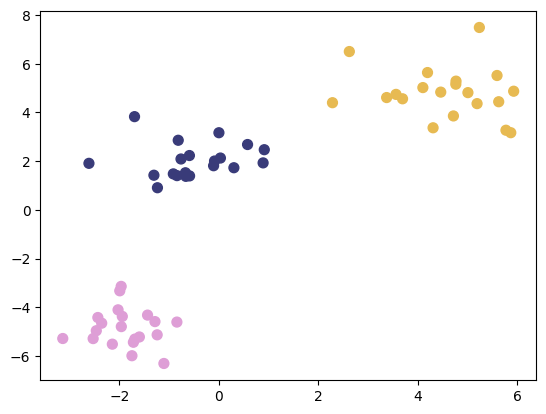

In [35]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=60, n_features=2, centers=3)
plot_2d_clf_problem(X, y)

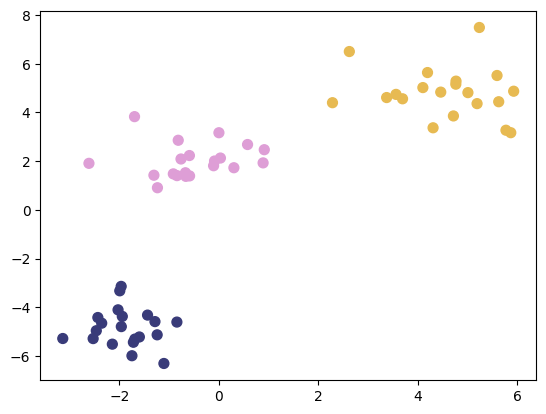

In [36]:
kmeans = KMeans(K=3)
y_pred = kmeans.predict(X)
plot_2d_clf_problem(X, y_pred)